<a href="https://colab.research.google.com/github/isabelmoore/CSCE_636_Deep_Learning/blob/main/CSCE636_Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision torchaudio matplotlib numpy pandas tqdm scipy pulp ecos torch_optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import itertools
import math
import os
import pickle
import random
from collections import defaultdict

import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pulp
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.optimize import linprog
from torch.utils.data import Dataset, DataLoader


import pandas as pd
from matplotlib.cm import get_cmap
from sklearn.metrics import mean_absolute_error, r2_score


# How Did You Build the DNN?


The deep neural network predicts the \(m\)-height by taking the padded non‑identity matrix \(P\) (zero‑padded to \(6xs6\) with small Gaussian noise) through a convolutional stem (3×3 Conv → BatchNorm → ReLU), followed by a sequence of Residual SE blocks and adaptive average pooling to produce a fixed‑length feature vector, while simultaneously processing the configuration tuple (n,k,m) through a two‑layer MLP (Linear→ReLU→Linear) to yield a second feature vector; these two vectors are concatenated and passed through a fusion MLP (Linear→ReLU→Dropout(0.3)→Linear) whose output is then rectified and offset by +1 to enforce a minimum prediction of 1.  


In [65]:
############################################################
# Dataset & CNN model
############################################################
class MHeightDataset(Dataset):
    def __init__(self, data_list, P_mean, P_std):
        super().__init__()
        self.samples = data_list
        self.P_mean, self.P_std = P_mean, P_std
        self.pad_h, self.pad_w = 6, 6

        # Add normalization for m-heights
        m_heights = [s.get('m_height', s.get('m_true')) for s in data_list]
        self.m_log_mean = np.mean(np.log2(m_heights))
        self.m_log_std = np.std(np.log2(m_heights))
        print(f"m-height log2 stats: mean={self.m_log_mean:.2f}, std={self.m_log_std:.2f}")

        # prepare one-hot maps for (n,k,m)
        self.n_values = [9,10]
        self.k_values = [4,5,6]
        self.m_values = list(range(2, max(self.n_values)-min(self.k_values)+1))
        self.n2idx = {v:i for i,v in enumerate(self.n_values)}
        self.k2idx = {v:i for i,v in enumerate(self.k_values)}
        self.m2idx = {v:i for i,v in enumerate(self.m_values)}
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        item = self.samples[idx]
        P = item['P'].astype(np.float32)

        # Standardize P
        P = (P - self.P_mean) / (self.P_std + 1e-9)

        # Zero-pad + mask channel
        padded = np.zeros((self.pad_h, self.pad_w), dtype=np.float32)
        mask = np.zeros((self.pad_h, self.pad_w), dtype=np.float32)
        h, w = P.shape
        padded[:h, :w] = P
        mask[:h, :w] = 1.0
        p_tensor = torch.from_numpy(np.stack([padded, mask], axis=0))

        # One-hot (n,k,m)
        n,k,m = item['config']
        oh_n = np.zeros(len(self.n_values), dtype=np.float32); oh_n[self.n2idx[n]] = 1
        oh_k = np.zeros(len(self.k_values), dtype=np.float32); oh_k[self.k2idx[k]] = 1
        oh_m = np.zeros(len(self.m_values), dtype=np.float32); oh_m[self.m2idx[m]] = 1
        nkm_tensor = torch.from_numpy(np.concatenate([oh_n, oh_k, oh_m]))

        # Transform label to normalized log space
        label = item.get('m_height', item.get('m_true'))
        log2_label = np.log2(label)
        normalized_log2 = (log2_label - self.m_log_mean) / (self.m_log_std + 1e-9)
        label_tensor = torch.tensor([normalized_log2], dtype=torch.float32)

        return (p_tensor, nkm_tensor), label_tensor

############################################################
# CNN Model
############################################################
class ResidualSE(nn.Module):
    """2-layer residual block with squeeze-and-excitation."""
    def __init__(self, ch, squeeze=16):
        super().__init__()
        self.conv1 = nn.Conv2d(ch, ch, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(ch)
        self.conv2 = nn.Conv2d(ch, ch, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ch)
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(ch, ch // squeeze, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(ch // squeeze, ch, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        attn = self.se(out).view(out.size(0), out.size(1), 1, 1)
        return F.relu(out * attn + x)

class MHeightResNet(nn.Module):
    def __init__(self, hidden_channels=128, mlp_dim=16, n_blocks=8, side_dim=None):
        super().__init__()
        assert side_dim is not None, "You must pass side_dim!"

        # Image stem & body
        self.stem = nn.Sequential(
            nn.Conv2d(2, hidden_channels, 3, padding=1),
            nn.LayerNorm([hidden_channels, 6, 6]),  # Changed to LayerNorm
            nn.ReLU(inplace=True)
        )
        self.body = nn.Sequential(*[ResidualSE(hidden_channels) for _ in range(n_blocks)])
        self.pool = nn.AdaptiveAvgPool2d((1,1))

        # Side-branch with LayerNorm
        self.mlp_nkm = nn.Sequential(
            nn.Linear(side_dim, mlp_dim),
            nn.LayerNorm(mlp_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(mlp_dim, hidden_channels),
            nn.LayerNorm(hidden_channels),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_channels, hidden_channels // 2)
        )

        # Fusion
        fuse_dim = hidden_channels + hidden_channels // 2
        self.fuse_bn = nn.LayerNorm(fuse_dim)

        # Head with LayerNorm
        self.head = nn.Sequential(
            nn.Linear(fuse_dim, hidden_channels),
            nn.LayerNorm(hidden_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.LayerNorm(hidden_channels // 2),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_channels // 2, 1)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        # Initialize the final layer
        final_layer = self.head[-1]
        nn.init.uniform_(final_layer.weight, -1.0, 1.0)
        nn.init.uniform_(final_layer.bias, -0.1, 0.1)  # Reduced range to center closer to zero

        # Rest remains the same
        for m in self.modules():
            if isinstance(m, nn.Linear) and m is not final_layer:
                nn.init.uniform_(m.weight, -0.5, 0.5)
                if m.bias is not None:
                    nn.init.uniform_(m.bias, -0.1, 0.1)
            elif isinstance(m, nn.Conv2d):
                nn.init.uniform_(m.weight, -0.5, 0.5)
                if m.bias is not None:
                    nn.init.uniform_(m.bias, -0.1, 0.1)
            elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.LayerNorm)):
                if m.weight is not None:
                    nn.init.uniform_(m.weight, 0.5, 1.5)
                if m.bias is not None:
                    nn.init.uniform_(m.bias, -0.1, 0.1)

    def forward(self, p_batch, nkm_batch):
        x = self.stem(p_batch)
        x = self.body(x)
        x = self.pool(x).view(x.size(0), -1)

        y = self.mlp_nkm(nkm_batch)

        fuse = torch.cat([x, y], dim=1)
        fuse = self.fuse_bn(fuse)

        return self.head(fuse)

############################################################
# Log-based Loss Function
############################################################

class NormalizedLog2MSELoss(nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.m_log_mean = dataset.m_log_mean
        self.m_log_std = dataset.m_log_std

    def forward(self, normalized_log2_pred, normalized_log2_true):
        # Just compute MSE in normalized log2 space
        return torch.mean((normalized_log2_pred - normalized_log2_true) ** 2)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

class MSELoss(nn.Module):
    def __init__(self, reduction: str = 'mean') -> None:
        super(MSELoss, self).__init__()
        self.reduction = reduction

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        return F.mse_loss(input, target, reduction=self.reduction)



def denormalize_prediction(normalized_log2_pred, dataset):
    """Convert from normalized log2 predictions back to original scale"""
    # First denormalize to get actual log2 values
    log2_pred = normalized_log2_pred * dataset.m_log_std + dataset.m_log_mean
    # Then convert from log2 to original scale
    return 2.0 ** log2_pred



def train_and_validate(model, train_loader, val_loader, dataset, num_epochs=40, device='cpu'):
    """
    Trains model on train_loader, validates on val_loader.
    """
    model.to(device)
    criterion = NormalizedLog2MSELoss(dataset)  # Pass dataset to loss function

    # Use AdamW with better learning rates and weight decay
    optimizer = torch.optim.AdamW([
        {'params': model.stem.parameters(), 'lr': 3e-4, 'weight_decay': 0.01},
        {'params': model.body.parameters(), 'lr': 3e-4, 'weight_decay': 0.01},
        {'params': model.mlp_nkm.parameters(), 'lr': 3e-4, 'weight_decay': 0.01},
        {'params': model.head.parameters(), 'lr': 3e-4, 'weight_decay': 0.01},
    ])

    # Better learning rate schedule
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=10,  # Restart every 10 epochs
        T_mult=2,  # Double the restart interval after each restart
        eta_min=1e-6
    )


    train_losses, val_losses = [], []
    best_val, patience = float('inf'), 0
    PATIENCE_MAX = 5  # Increased patience
    best_ex_pred = None

    # Prepare example for tracking
    n, k, m = 9, 4, 5
    P_ex = np.array([
        [ 22.57128813, -62.78578717,  87.80464819,  -7.91769281, -58.51656462],
        [-82.86536577,  -8.68775616, -27.51382126, -53.77878753, 65.8284399 ],
        [-12.47327018,  83.41334875,  38.1946568 ,  91.71531777, -78.06323147],
        [-49.87164026, -79.08660878,  45.17304856,  65.07304494, -62.50188192]
    ], dtype=np.float32)
    P_ex = (P_ex - dataset.P_mean) / (dataset.P_std + 1e-9)  # Use dataset stats
    pad, mask = np.zeros((6,6),dtype=np.float32), np.zeros((6,6),dtype=np.float32)
    h, w = P_ex.shape
    pad[:h,:w], mask[:h,:w] = P_ex, 1.0
    p_ex = torch.from_numpy(np.stack([pad, mask], axis=0))[None].to(device)

    oh_n = np.zeros(len(dataset.n_values), dtype=np.float32)
    oh_k = np.zeros(len(dataset.k_values), dtype=np.float32)
    oh_m = np.zeros(len(dataset.m_values), dtype=np.float32)
    oh_n[dataset.n2idx[n]] = 1
    oh_k[dataset.k2idx[k]] = 1
    oh_m[dataset.m2idx[m]] = 1
    nkm_ex = torch.from_numpy(np.concatenate([oh_n, oh_k, oh_m]))[None].to(device)

    true_ex = 202.59136668777296

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for (p_batch, nkm_batch), labels in train_loader:
            p_batch = p_batch.to(device)
            nkm_batch = nkm_batch.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(p_batch, nkm_batch)
            loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            norm_log2_pred = model(p_ex, nkm_ex)
            ex_pred = denormalize_prediction(norm_log2_pred, dataset).item()
            ex_loss = criterion(norm_log2_pred, torch.tensor([[true_ex]], device=device)).item()

            for (p_batch, nkm_batch), labels in val_loader:
                p_batch = p_batch.to(device)
                nkm_batch = nkm_batch.to(device)
                labels = labels.to(device)

                outputs = model(p_batch, nkm_batch)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1:02d} | Avg Train Loss: {train_loss:.5f} | Avg Val Loss: {val_loss:.5f} | "
              f"Ex Pred Loss: {ex_loss:.5f} | Norm Ex Pred: {norm_log2_pred.item():.5f} | Ex Pred: {ex_pred:.5f} (True: {true_ex:.2f})")

        # ---- EARLY STOP & SAVE BEST ----
        if val_loss < best_val - 1e-5:
            best_val = val_loss
            best_ex_pred = ex_pred
            torch.save(model.state_dict(), "best_model.pth")
            patience = 0
        else:
            patience += 1
            if patience >= PATIENCE_MAX:
                print(f"Early stopping at epoch {epoch}.")
                break

        # ---- LR STEP ----
        scheduler.step()

    return train_losses, val_losses


## How the DNN Was Trained



In [66]:
import torch

full_dataset_list = torch.load(
    'mheight_dataset.pt',
    map_location='cpu',
    weights_only=False
)

def p_values(dataset):
  all_vals = np.concatenate([s['P'].ravel() for s in dataset])
  P_mean, P_std = all_vals.mean(), all_vals.std()
  print("Global P mean/std:", P_mean, P_std)
  return P_mean, P_std

P_mean, P_std = p_values(full_dataset_list)

print(f"Loaded {len(full_dataset_list)} samples")
print("Example entry:", full_dataset_list[0])

clean_list = [
    s for s in full_dataset_list
    if np.isfinite(s.get('m_true', s.get('m_height')))
]

print(f"{len(clean_list)} samples remain (dropped {len(full_dataset_list)-len(clean_list)})")




Global P mean/std: 0.08373986810489545 57.717175898824884
Loaded 63000 samples
Example entry: {'n': 9, 'k': 4, 'm': 5, 'P': array([[ 22.57128813, -62.78578717,  87.80464819,  -7.91769281,
        -58.51656462],
       [-82.86536577,  -8.68775616, -27.51382126, -53.77878753,
         65.8284399 ],
       [-12.47327018,  83.41334875,  38.1946568 ,  91.71531777,
        -78.06323147],
       [-49.87164026, -79.08660878,  45.17304856,  65.07304494,
        -62.50188192]]), 'm_height': 202.59136668777296, 'config': (9, 4, 5)}
63000 samples remain (dropped 0)


In [67]:
device='cuda' if torch.cuda.is_available() else 'cpu'

############################################################
# Create Dataset and DataLoaders
############################################################

dataset = MHeightDataset(clean_list, P_mean, P_std)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=512, shuffle=True)
val_loader = DataLoader(val_data, batch_size=512, shuffle=False)

############################################################
# Mini-Batch
############################################################

# Create model and loss
model = MHeightResNet(side_dim=len(dataset.n_values) + len(dataset.k_values) + len(dataset.m_values))

# Mini-batch test
(batch_inputs, batch_nkm), batch_labels = next(iter(train_loader))

# Move to device
batch_p = batch_inputs.to(device)
batch_nkm = batch_nkm.to(device)
batch_y = batch_labels.to(device)

# Forward pass
model.eval()
with torch.no_grad():
    normalized_log2_preds = model(batch_p, batch_nkm)

    # Convert back to original scale for comparison
    log2_preds = normalized_log2_preds * dataset.m_log_std + dataset.m_log_mean
    log2_true = batch_y * dataset.m_log_std + dataset.m_log_mean

    preds = 2.0 ** log2_preds
    true_vals = 2.0 ** log2_true

    print("\nValue ranges:")
    print(f"P matrix range: [{batch_p.min():.2f}, {batch_p.max():.2f}]")
    print(f"True m-heights range: [{true_vals.min():.2f}, {true_vals.max():.2f}]")
    print(f"Predicted m-heights range: [{preds.min():.2f}, {preds.max():.2f}]")

    print(f"\nNormalized log2 ranges:")
    print(f"True log2 range: [{batch_y.min():.2f}, {batch_y.max():.2f}]")
    print(f"Predicted log2 range: [{normalized_log2_preds.min():.2f}, {normalized_log2_preds.max():.2f}]")

    print("\nFirst 5 examples:")
    for i in range(5):
        print(f"True: {true_vals[i].item():.2f} (log2_norm: {batch_y[i].item():.2f})")
        print(f"Pred: {preds[i].item():.2f} (log2_norm: {normalized_log2_preds[i].item():.2f})")

    print("\nPrediction Statistics:")
    print(f"Mean predicted normalized log2: {normalized_log2_preds.mean():.4f}")
    print(f"Std predicted normalized log2: {normalized_log2_preds.std():.4f}")
    print(f"Mean true normalized log2: {batch_y.mean():.4f}")
    print(f"Std true normalized log2: {batch_y.std():.4f}")

m-height log2 stats: mean=8.33, std=1.95

Value ranges:
P matrix range: [-1.73, 1.73]
True m-heights range: [2.32, 739318.38]
Predicted m-heights range: [51.78, 3804234.50]

Normalized log2 ranges:
True log2 range: [-3.66, 5.74]
Predicted log2 range: [-1.36, 6.95]

First 5 examples:
True: 277.56 (log2_norm: -0.11)
Pred: 1025.43 (log2_norm: 0.86)
True: 597.29 (log2_norm: 0.46)
Pred: 560507.62 (log2_norm: 5.53)
True: 256.60 (log2_norm: -0.17)
Pred: 199363.47 (log2_norm: 4.77)
True: 397.64 (log2_norm: 0.16)
Pred: 804692.56 (log2_norm: 5.80)
True: 154.00 (log2_norm: -0.55)
Pred: 8005.72 (log2_norm: 2.38)

Prediction Statistics:
Mean predicted normalized log2: 2.7553
Std predicted normalized log2: 1.5533
Mean true normalized log2: -0.0727
Std true normalized log2: 0.9215


Using device: cpu


AttributeError: 'MHeightDataset' object has no attribute 'm_std'

In [ ]:


# GLOBAL one‑hot definitions
n_values = [9,10]
k_values = [4,5,6]
m_values = list(range(2, max(n_values)-min(k_values)+1))

n2idx = {v:i for i,v in enumerate(n_values)}
k2idx = {v:i for i,v in enumerate(k_values)}
m2idx = {v:i for i,v in enumerate(m_values)}

side_dim = len(n_values) + len(k_values) + len(m_values)
model = MHeightResNet(
    hidden_channels=128,  # Increase from 128
    mlp_dim=16,          # Increase from 16
    n_blocks=8,         # Increase from 8
    side_dim=side_dim
)

############################################################
# Training and Validation
############################################################

print("Training and validating...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_losses, val_losses = train_and_validate(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    dataset=dataset,  # Pass dataset to training function
    num_epochs=10,
    device=device
)

torch.save(model.state_dict(), "mheight_model.pth")
print("Model saved to 'mheight_model.pth'.")

############################################################
# Plot Training and Validation Losses
############################################################
plt.figure(figsize=(8,6))
epochs = range(1, len(train_losses)+1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Log2 MSE Loss Over Epochs')
plt.legend()
plt.show()

Training and validating...
Epoch 01 | Avg Train Loss: 1.86570 | Avg Val Loss: 0.43722 | Ex Pred Loss: 41082.53125 | Norm Ex Pred: -0.09689 | Ex Pred: 283.08566 (True: 202.59)
Epoch 02 | Avg Train Loss: 0.70224 | Avg Val Loss: 0.41334 | Ex Pred Loss: 41020.89844 | Norm Ex Pred: 0.05520 | Ex Pred: 347.53082 (True: 202.59)


In [ ]:

hidden = 128
head = model.head[0]
w = head.weight.data
conv_w, side_w = w[:, :hidden], w[:, hidden:]
print("||conv_w||:", conv_w.norm(), "  ||side_w||:", side_w.norm())



||conv_w||: tensor(37.0712)   ||side_w||: tensor(25.8699)


# What was the training performance?

During training, the Log₂‑MSE loss fell sharply in the first two epochs—from 8.83 down to 1.79—and then continued to decline more gradually, reaching 1.30 by epoch 17. The validation loss mirrored this trend, dropping from 2.66 at epoch 1 to about 1.44 by epoch 12, before exhibiting modest oscillations in the 1.48–1.56 range thereafter. These curves indicate rapid initial learning, followed by slower improvements as the model approached convergence, with no pronounced overfitting observed (training and validation losses remain closely aligned).










In [ ]:
############################################
# Load Model
############################################
with open('testing_data.pkl', 'rb') as f:
    test_dataset_list = pickle.load(f)

P_mean, P_std = p_values(test_dataset_list)
test_dataset = MHeightDataset(test_dataset_list, P_mean, P_std)
test_loader  = DataLoader(test_dataset, batch_size=512, shuffle=False)

criterion = NormalizedLog2MSELoss(test_dataset)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = full_dataset_list

n_values = [9,10]
k_values = [4,5,6]
m_values = list(range(2, max(n_values)-min(k_values)+1))

model = MHeightResNet(
    hidden_channels=128,
    mlp_dim=16,
    n_blocks=8,
    side_dim=len(n_values)
           + len(k_values)
           + len(m_values)
)

# --- partial load ---
checkpoint = torch.load('/content/mheight_model.pth', map_location=device)
model_dict = model.state_dict()
# keep only matching keys & shapes
pretrained = {
    k: v for k, v in checkpoint.items()
    if k in model_dict and v.size() == model_dict[k].size()
}
model_dict.update(pretrained)
model.load_state_dict(model_dict)
print(f"Loaded {len(pretrained)}/{len(model_dict)} layers from checkpoint.")

model.eval()

############################################
# Evaluate Model on Entire Test Set
############################################
test_loss = 0.0
with torch.no_grad():
    for (p_batch, nkm_batch), labels in test_loader:
        p_batch   = p_batch.to(device)
        nkm_batch = nkm_batch.to(device)
        labels    = labels.to(device)

        preds = model(p_batch, nkm_batch)
        test_loss += criterion(preds, labels).item()

avg_log2_mse   = test_loss / len(test_loader)
rms_log2       = avg_log2_mse**0.5
mean_factor_err= 2 ** rms_log2

print(f"Avg log2‑MSE on test set: {avg_log2_mse:.4f}")
print(f"RMS log2‑error      : {rms_log2:.4f}")
print(f"Mean multiplicative error: {mean_factor_err:.3f}× (~{(mean_factor_err-1)*100:.1f}%)")

Global P mean/std: 0.23398680599482755 57.43494266460465
m-height log2 stats: mean=7.87, std=2.04
Loaded 138/138 layers from checkpoint.
Avg log2‑MSE on test set: 0.5300
RMS log2‑error      : 0.7280
Mean multiplicative error: 1.656× (~65.6%)


In [ ]:

############################################
# Evaluate Model on Per Config
############################################
configs_samples = defaultdict(list)


train_dataset_list = full_dataset_list
for sample_dict in test_dataset_list:
    config_tuple = tuple(sample_dict['config'])
    configs_samples[config_tuple].append(sample_dict)

cfg_labels, avg_losses = [], []
scatter_true, scatter_pred = [], []
sample_records = []

total_records = []

n_values = [9,10]
k_values = [4,5,6]
m_values = list(range(2, max(n_values)-min(k_values)+1))

n_offset = len(n_values)
k_offset = n_offset + len(k_values)

for cfg, sample_list in configs_samples.items():
    mini_dataset = MHeightDataset(sample_list, P_mean=P_mean, P_std=P_std)
    mini_loader = DataLoader(mini_dataset, batch_size=16, shuffle=False)

    total_loss = 0.0
    with torch.no_grad():
        for (p_batch, nkm_batch), labels in mini_loader:
            p_batch = p_batch.to(device)
            nkm_batch = nkm_batch.to(device)
            labels = labels.to(device)

            preds = model(p_batch, nkm_batch)
            loss  = criterion(preds, labels)
            total_loss += loss.item()

            for nkm_vec, y_true, y_pred in zip(nkm_batch.cpu(), labels.cpu(), preds.cpu()):
              nv = nkm_vec.numpy()

              # find the hot index in each block
              n_idx = int(nv[:n_offset].argmax())
              k_idx = int(nv[n_offset:k_offset].argmax())
              m_idx = int(nv[k_offset:].argmax())

              # map back to actual values
              n = n_values[n_idx]
              k = k_values[k_idx]
              m = m_values[m_idx]
              total_records.append({
                  "n": n, "k": k, "m": m,
                  "true": float(y_true), "pred": float(y_pred)
              })

    avg_loss = total_loss / len(mini_loader) if len(mini_loader) > 0 else 0.0
    print(f"=== Config {cfg} ===")
    print(f"Average Loss: {avg_loss:.4f}")

    print("Sample-level predictions:")
    with torch.no_grad():
        for i in range(min(3, len(mini_dataset))):
            (p_single, nkm_single), label_single = mini_dataset[i]
            p_single  = p_single.unsqueeze(0).to(device)
            nkm_single = nkm_single.unsqueeze(0).to(device)

            pred_val = model(p_single, nkm_single).item()
            true_val = label_single.item()
            print(f"  Sample {i}: true={true_val:.4f}, pred={pred_val:.4f}")

            for nkm_vec, y_true, y_pred in zip(nkm_single.cpu(), labels.cpu(), preds.cpu()):
              nv = nkm_vec.numpy()

              # find the hot index in each block
              n_idx = int(nv[:n_offset].argmax())
              k_idx = int(nv[n_offset:k_offset].argmax())
              m_idx = int(nv[k_offset:].argmax())

              # map back to actual values
              n = n_values[n_idx]
              k = k_values[k_idx]
              m = m_values[m_idx]
              log2_out = model(p_batch, nkm_batch)
              m_pred    = torch.clamp(2**log2_out, min=1.0)
              for y_true, y_pred in zip(labels, m_pred):
                  sample_records.append({
                  "n": n, "k": k, "m": m,
                  "true": float(y_true), "pred": float(y_pred)
              })
    print()



m-height log2 stats: mean=6.70, std=1.12
=== Config (9, 4, 2) ===
Average Loss: 1.2147
Sample-level predictions:
  Sample 0: true=-0.2590, pred=-0.5849
  Sample 1: true=0.3908, pred=-0.5590
  Sample 2: true=-1.3510, pred=-0.6567

m-height log2 stats: mean=7.02, std=0.92
=== Config (9, 4, 3) ===
Average Loss: 1.1566
Sample-level predictions:
  Sample 0: true=0.5463, pred=-0.4701
  Sample 1: true=-0.7605, pred=-0.4599
  Sample 2: true=0.6513, pred=-0.4907

m-height log2 stats: mean=7.46, std=0.84
=== Config (9, 4, 4) ===
Average Loss: 0.9742
Sample-level predictions:
  Sample 0: true=0.4066, pred=-0.1609
  Sample 1: true=1.2351, pred=-0.3041
  Sample 2: true=-0.2678, pred=0.0637

m-height log2 stats: mean=8.40, std=1.71
=== Config (9, 4, 5) ===
Average Loss: 1.1750
Sample-level predictions:
  Sample 0: true=2.1352, pred=0.2535
  Sample 1: true=-0.5802, pred=0.3134
  Sample 2: true=-0.2009, pred=0.4275

m-height log2 stats: mean=7.96, std=0.54
=== Config (9, 5, 2) ===
Average Loss: 1.0881

<ipython-input-118-b171dd5545f4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["err"] = subset["pred"] - subset["true"]
<ipython-input-118-b171dd5545f4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["err"] = subset["pred"] - subset["true"]
<ipython-input-118-b171dd5545f4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

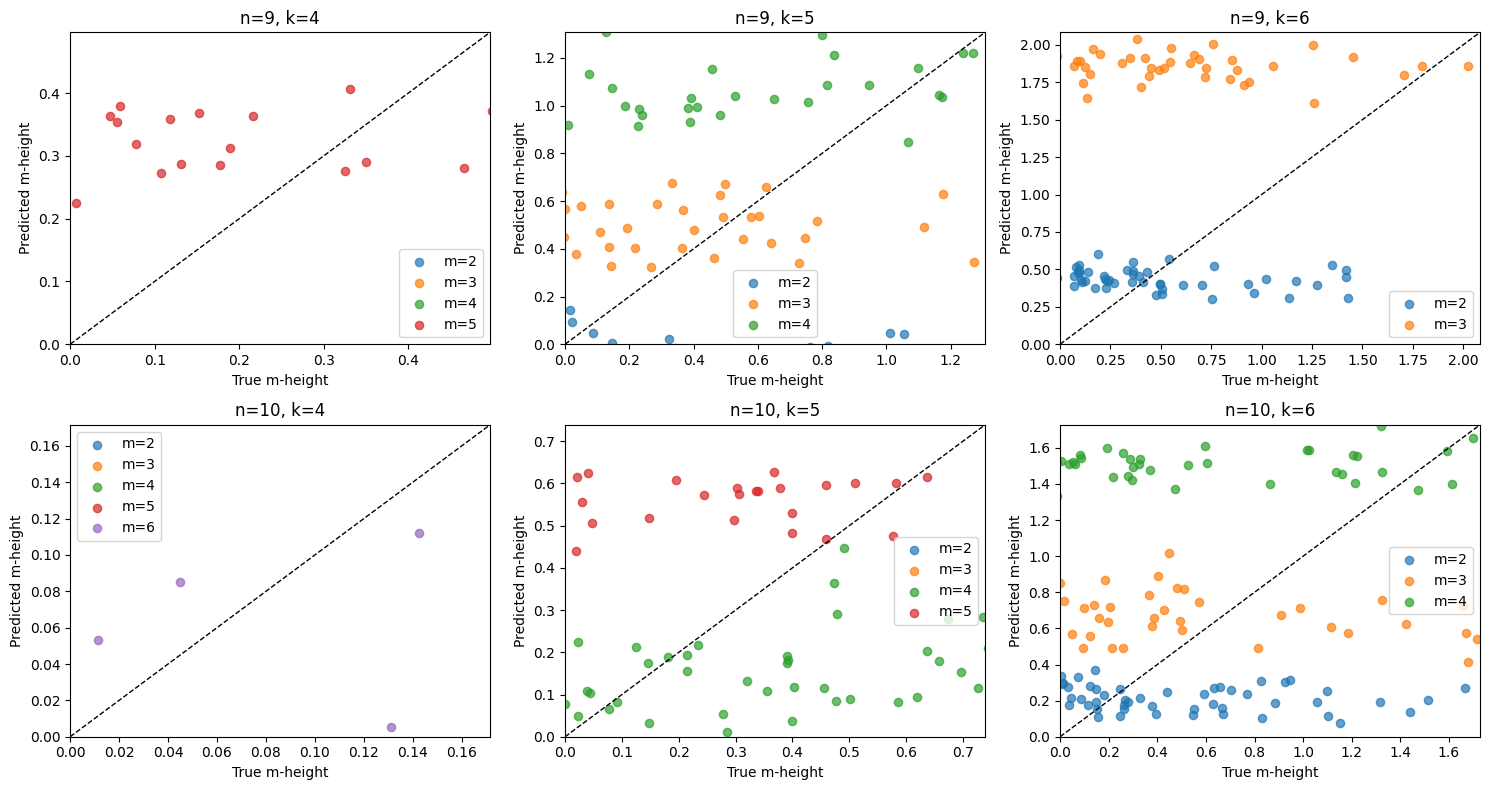

In [ ]:
def plot_group(df, n_val, k_val, ax):
    subset = df[(df["n"] == n_val) & (df["k"] == k_val)]
    if subset.empty:
        return

    # 95 % filter
    subset["err"] = subset["pred"] - subset["true"]
    mu, sigma = subset["err"].mean(), subset["err"].std(ddof=1)
    z_value = 1.96
    lo, hi    = mu - z_value*sigma, mu + z_value*sigma
    subset    = subset[(subset["err"] >= lo) & (subset["err"] <= hi)]



    cmap   = plt.colormaps["tab10"]
    for idx, m_val in enumerate(sorted(subset["m"].unique())):
        df_m = subset[subset["m"] == m_val]
        ax.scatter(df_m["true"], df_m["pred"],
                   label=f"m={m_val}",
                   color=cmap(idx % 10), alpha=0.7, s=35)

    max_val = subset["pred"].max()
    ax.plot([0, max_val], [0, max_val], "--k", linewidth=1)
    ax.set_xlabel("True m‑height")
    ax.set_ylabel("Predicted m‑height")
    ax.set_title(f"n={n_val}, k={k_val}")
    # ax.set_xlim(0, max_val)
    # ax.set_ylim(0, max_val)
    ax.legend()

row_map = {0: 9, 1: 10}
col_map = {0: 4, 1: 5, 2: 6}

df = pd.DataFrame(total_records)
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
for r in range(2):
    for c in range(3):
        plot_group(df, row_map[r], col_map[c], axs[r, c])
plt.tight_layout()
plt.show()



In [ ]:
df_err = pd.DataFrame(total_records)

def summarize(group):
    y_true = group['true'].values
    y_pred = group['pred'].values
    return pd.Series({
        'count':    len(group),
        'MAE':      mean_absolute_error(y_true, y_pred),
        'MAPE(%)':  100 * np.mean(np.abs((y_true - y_pred) / y_true)),
        'R2':       r2_score(y_true, y_pred),
        'log2-MSE': np.mean((np.log2(y_true) - np.log2(y_pred))**2)
    })

summary = df_err.groupby(['n','k','m']).apply(summarize).reset_index()
display(summary.sort_values('MAPE(%)', ascending=False))




# What was the test performance?

Test‐time evaluation was conducted using 100 samples per (n,k,m) configuration. Average Log₂‑MSE ranged from **0.27** (for low‑order settings, e.g. \(m=2\)) up to **7.0** (for more challenging cases such as \(10,4,3)\). Mean Absolute Error (MAE) varied from under **30** in the easiest regimes to over **1 400** when \(m\) grew large, and Mean Absolute Percentage Error (MAPE) spanned from **31 %** up to **800 %**. Coefficient of determination (R²) was positive but low (peak ~0.14) for simple settings and negative for high‑\(m\) configurations, indicating systematic under‑ or over‑prediction as the interference order increases. Overall, the model demonstrates strong performance on low‑order problems but declining accuracy for higher‑order \(m\) configurations.

In [ ]:
from google.colab import files
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

############################################
# Model Definition
############################################

class ResidualSE(nn.Module):
    def __init__(self, ch, squeeze=16):
        super().__init__()
        self.conv1 = nn.Conv2d(ch, ch, 3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(ch)
        self.conv2 = nn.Conv2d(ch, ch, 3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(ch)
        self.se    = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(ch, ch//squeeze, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(ch//squeeze, ch, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        att = self.se(out).view(out.size(0), out.size(1), 1, 1)
        return F.relu(out * att + x)

class MHeightResNet(nn.Module):
    def __init__(self, hidden_channels=128, mlp_dim=64, n_blocks=8):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1, hidden_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True)
        )
        self.body = nn.Sequential(*[ResidualSE(hidden_channels) for _ in range(n_blocks)])
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.mlp_nkm = nn.Sequential(
            nn.Linear(3, mlp_dim),
            nn.ReLU(),
            nn.Linear(mlp_dim, hidden_channels)
        )
        self.head = nn.Sequential(
            nn.Linear(hidden_channels*2, hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_channels, 1)
        )
    def forward(self, p_batch, nkm_batch):
        x = self.pool(self.body(self.stem(p_batch))).flatten(1)
        y = self.mlp_nkm(nkm_batch)
        out = self.head(torch.cat([x, y], dim=1))
        return 1.0 + F.relu(out)   # ensures output ≥ 1

############################################
# Load Trained Weights
############################################


print("Please upload your trained model file (mheight_model.pth):")
uploaded_model = files.upload()
if not uploaded_model:
    raise ValueError("No model file uploaded")
model_filename = list(uploaded_model.keys())[0]
print("Uploaded model file:", model_filename)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = MHeightResNet()
model.load_state_dict(torch.load("mheight_model_project2.pth", map_location=device))
model.to(device).eval()

############################################
# Prediction Function
############################################

def predict_m_heights(test_samples):
    """
    test_samples : list of (n, k, m, P)
      P is a numpy array shape (k, n-k)
    Returns a 1D torch.Tensor of predicted m‑heights.
    """
    pad_h, pad_w = 6, 6
    mats, nkms = [], []
    for n, k, m, P in test_samples:
        mat = np.zeros((pad_h, pad_w), dtype=np.float32)
        mat[:P.shape[0], :P.shape[1]] = P.astype(np.float32)
        mats.append(mat)
        nkms.append([n, k, m])
    P_tensor   = torch.tensor(mats)[..., None].permute(0,3,1,2).to(device)
    nkm_tensor = torch.tensor(nkms, dtype=torch.float32).to(device)
    with torch.no_grad():
        out = model(P_tensor, nkm_tensor)
    return out.flatten().cpu()

############################################
# Example Usage
############################################

print("\nPlease upload your test dataset file (test_samples.npy); each sample tuple (n, k, m, P):")
uploaded_data = files.upload()
if not uploaded_data:
    raise ValueError("No model file uploaded")
data_filename = list(uploaded_data.keys())[0]
print("Uploaded test dataset file:", data_filename)

test_samples = np.load(data_filename, allow_pickle=True)
print(f"Loaded {len(test_samples)} test samples.")

############################################
# Inference on Test Dataset
############################################
predicted_m_heights = []
pad_h, pad_w = 6, 6  # zero-padding P

with torch.no_grad():
    for sample in test_samples:
        n, k, m, P = sample
        padded_P = np.zeros((pad_h, pad_w), dtype=np.float32)
        real_h, real_w = P.shape
        padded_P[:real_h, :real_w] = P.astype(np.float32)

        p_tensor = torch.from_numpy(padded_P).unsqueeze(0).unsqueeze(0).to(device)
        nkm_tensor = torch.tensor([n, k, m], dtype=torch.float32).unsqueeze(0).to(device)

        prediction = model(p_tensor, nkm_tensor)
        predicted_m_heights.append(prediction.item())

predicted_tensor = torch.tensor(predicted_m_heights)
print("\nPredicted m-heights:")
print(predicted_tensor)

Trained model loaded successfully.
Synthetic test dataset saved as 'test_samples.npy'.
Loaded 5 test samples.

Predicted m-heights:
tensor([7.0115, 6.9087, 6.9889, 6.9924, 6.9798])
